In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [1]:
import numpy as np
import tensorflow as tf

In [2]:
from importlib import reload

In [3]:
import retina_net_model as r_n_model
reload(r_n_model)

model = r_n_model.get_model()

PredictionDecoder = r_n_model.PredictionDecoder
lencode = r_n_model.LabelEncoder()

In [4]:
import image_util as imutil
import data_util as dutil



dutil = reload(dutil)
imutil = reload(imutil)

imaug = imutil.ImageAugmenter()
imaug_val = imutil.ImageAugmenter()
preprocess_images = imutil.preprocess_image

datawalker = dutil.DataWalker(["../data/20190424190300041510/marmot_dataset_v1.0/data/"
                               ,"../data/TRACKA_training/","../data/TRACKA_test/"
                               ,"../data/TRACKB1_test/","../data/TRACKB_training/"],
                            marmot_index = [0],
                            wild_bank = ["../data/RealTable/train/",True] 
                            #table_bank = ["../data/TableBank/Detection/","tablebank_latex_train.json",True]
                            )

#datawalker = dutil.DataWalker([],
#                              marmot_index = [],
#                              table_bank = ["../data/TableBank/Detection/","tablebank_latex_val.json",True])

labels,image_file_paths,norms_flag = datawalker.process_all_dirs()


#datawalker2 = dutil.DataWalker(["../data/TRACKA_test/","../data/TRACKB2_test/"])
datawalker2 = dutil.DataWalker(#["../data/TRACKB2_test/"],
                               [],wild_bank = ["../data/RealTable/test/",True],
                              marmot_index = [])
                              #table_bank = ["../data/TableBank/Detection/","tablebank_latex_val.json",True])
labels_test,image_file_paths_test,norms_flag_val = datawalker2.process_all_dirs()

In [5]:
from random import shuffle
class DataGen:
    def __init__(self,image_file_paths,labels,norms_flag,imaug,training_flag = False):
        assert len(image_file_paths) == len(labels) , "Length of label not equal to length of images"
        self.num_image = len(image_file_paths)
        
        self.image_file_paths = image_file_paths
        
        self.indexes = [i for i in range(self.num_image)]
        shuffle(self.indexes)
        
        self.imaug = imaug
        self.labels = labels
        self.norms_flag = norms_flag
        self.cur_indx = 0
        
        self.training_flag = training_flag
        self.imaug.training_flag = training_flag
    
    def get_next_index(self):
        if self.cur_indx == self.num_image - 1:
            self.cur_indx = 0
            shuffle(self.indexes)
        else:
            self.cur_indx += 1
        return
    
    def get_next_path(self):
        #print("Path Considered",self.image_file_paths[self.cur_indx])
        return self.image_file_paths[self.indexes[self.cur_indx]]
    
    def get_next_label(self):
        return self.labels[self.indexes[self.cur_indx]]
    
    def get_next_norm_flag(self):
        return self.norms_flag[self.indexes[self.cur_indx]]
    
    def next_element(self):
        return self.imaug.get_raw_image(self.get_next_path()),self.get_next_label(),self.get_next_norm_flag()
    
    def get_next(self):
        for _ in range(self.num_image):
            img1,labels,norm_flag = self.next_element()
            
            #extender = 0
            #if self.training_flag:
                #img1,extender = self.imaug.get_distotred_image(img1)
                #labels += np.asarray([extender,extender,0,0,0])
            
            #img1,img2,img3 = images
            if norm_flag:
                img_shape = img1.shape
                labels = np.stack([
                    labels[...,0]*img_shape[1],labels[...,1]*img_shape[0],
                    labels[...,2]*img_shape[1],labels[...,3]*img_shape[0],labels[...,4]
                ],axis = -1)
                
            if self.training_flag:
                img1t = self.imaug.get_thresholded_image(self.get_next_path())
            #    
            #    img2t = self.imaug.get_raw_thres_image(self.get_next_path())
            #    img2t = self.imaug.get_3d_image(img2t)
            #    
                yield preprocess_images(img1t,labels,training_flag = False)
            #    nimg = (img1t/255.0) > 0.15
            #    nimg = (nimg*255.0).astype(np.uint8)
            #       
            #    n2img = (img2t/255.0) > 0.15
            #    n2img = (n2img*255.0).astype(np.uint8)
            #    
            #    yield preprocess_images(nimg,labels,training_flag = False)
            #    yield preprocess_images(n2img,labels,training_flag = False)
                
            yield preprocess_images(img1,labels,training_flag = self.training_flag)
            
            #yield preprocess_images(img2,labels,training_flag = self.training_flag)
            #yield preprocess_images(img3,labels,training_flag = self.training_flag)
            
            self.get_next_index()
            
train_gen = DataGen(image_file_paths,labels,norms_flag,imaug,training_flag = True)
val_gen = DataGen(image_file_paths_test,labels_test,norms_flag_val,imaug_val)

In [6]:
reload(r_n_model)
lencode = r_n_model.LabelEncoder()

autotune = tf.data.AUTOTUNE
batch_size = 1

imutil = reload(imutil)
preprocess_images = imutil.preprocess_image

train_data = tf.data.Dataset.from_generator(train_gen.get_next,
                                                   output_signature = (
                                                       tf.TensorSpec(shape = (None,None,3),dtype = tf.float32),
                                                       tf.TensorSpec(shape = (None,4),dtype = tf.float32),
                                                       tf.TensorSpec(shape = (None,), dtype = tf.int32)
                                                   ))

#train_data = train_data.shuffle(batch_size*2)

train_data = train_data.padded_batch(batch_size= batch_size,padding_values=(0.0,1e-8,-1))
train_data = train_data.map(lencode.encode_batch, num_parallel_calls = autotune)

train_data = train_data.apply(tf.data.experimental.ignore_errors())
train_data = train_data.prefetch(autotune)

val_data = tf.data.Dataset.from_generator(val_gen.get_next,
                                                   output_signature = (
                                                       tf.TensorSpec(shape = (None,None,3),dtype = tf.float32),
                                                       tf.TensorSpec(shape = (None,4),dtype = tf.float32),
                                                       tf.TensorSpec(shape = (None,), dtype = tf.int32)
                                                   ))

val_data = val_data.padded_batch(batch_size= 1,padding_values=(0.0,1e-8,-1))
val_data = val_data.map(lencode.encode_batch, num_parallel_calls = autotune)


val_data = val_data.apply(tf.data.experimental.ignore_errors())
val_data = val_data.prefetch(autotune)

In [48]:
weights_dir = "./model_dir_resnet_50_table_4pixel_table_bank_2/"

latest_checkpoint = tf.train.latest_checkpoint(weights_dir)
model.load_weights(latest_checkpoint)

In [8]:
len(labels),len(labels_test)

(14733, 3611)

In [15]:
import os
model_dir = "./model_dir_resnet_50_table_4pixel_table_bank_3/"
callback_li = [
            tf.keras.callbacks.ModelCheckpoint(
            #filepath=os.path.join(model_dir, "weights" + "__epochs_{epoch}"),
            filepath = os.path.join(model_dir,"latest"),
                monitor = "loss",
            save_best_only=True,
            save_weights_only=True,
            verbose=1l
        )
    ]


#validation_data = val_data

model.fit(train_data,validation_data = val_data,epochs = 8,verbose=1,callbacks=callback_li)

Epoch 1/8
29466/29466 [==============================] - 14716s 499ms/step - loss: 0.0673 - val_loss: 0.2680

Epoch 00001: loss improved from inf to 0.06725, saving model to ./model_dir_resnet_50_table_4pixel_table_bank_3\latest
Epoch 2/8
29466/29466 [==============================] - 20432s 693ms/step - loss: 0.0668 - val_loss: 0.2614

Epoch 00002: loss improved from 0.06725 to 0.06677, saving model to ./model_dir_resnet_50_table_4pixel_table_bank_3\latest
Epoch 3/8
29466/29466 [==============================] - 14878s 505ms/step - loss: 0.0661 - val_loss: 0.2358

Epoch 00003: loss improved from 0.06677 to 0.06608, saving model to ./model_dir_resnet_50_table_4pixel_table_bank_3\latest
Epoch 4/8
29466/29466 [==============================] - 14706s 499ms/step - loss: 0.0649 - val_loss: 0.2753

Epoch 00004: loss improved from 0.06608 to 0.06490, saving model to ./model_dir_resnet_50_table_4pixel_table_bank_3\latest
Epoch 5/8
29466/29466 [==============================] - 14709s 499ms/st

In [50]:
from random import shuffle
from glob import glob
reload(r_n_model)

im_test = glob("../data/custom_data/*.jpeg")
#im_test = image_file_paths
gb_path = None
image = tf.keras.Input(shape=[None, None, 3], name="image")

predictions = model(image, training=False)
detections = r_n_model.PredictionDecoder(confidence_threshold=0.05)(image, predictions)
inference_model = tf.keras.Model(inputs=image, outputs=detections)



imutil = reload(imutil)

imaug_ = imutil.ImageAugmenter()

class TestDateGen:
    def __init__(self,image_file_paths,imaug):
        self.num_image = len(image_file_paths)
        
        self.image_file_paths = image_file_paths
    
        self.indexes = [i for i in range(self.num_image)]
        shuffle(self.indexes)
        
        self.imaug = imaug_
        
        self.labels = labels
        self.cur_indx = 0
    def get_next_index(self):
        if self.cur_indx == self.num_image:
            self.cur_indx = 0
            shuffle(self.indexes)
        self.cur_indx += 1
        return
    
    def process_image_for_prediction(self,image):
        image,_,ratio = imutil.resize_pad_image(image,jitter = None)
        image = tf.keras.applications.resnet.preprocess_input(image)
        return image,ratio
   
    def get_next_path(self):
        global gb_path
        print("Path Considered",self.image_file_paths[self.cur_indx])
        gb_path = self.image_file_paths[self.cur_indx]
        return self.image_file_paths[self.cur_indx]
    
    def get_next_label(self):
        return self.labels[self.cur_indx]

    def get_next_set(self):
        for i in self.indexes:
            self.cur_indx = i
            image = self.imaug.get_raw_image(self.get_next_path())
            
            img1t = self.imaug.get_thresholded_image(self.get_next_path())
            nimg = ((img1t/255.0) > 0.1)*255
            
            nimg = nimg.astype(np.uint8)
            
            nimg = cv2.erode(nimg,kernel = np.ones((10,10)),iterations = 1)
            
            #showImage(nimg)
            img,rtio = self.process_image_for_prediction(image)
            yield img,rtio
            #self.get_next_index()
            
tdgen = TestDateGen(im_test,imaug_val)
test_data = tf.data.Dataset.from_generator(tdgen.get_next_set,
                                                   output_signature = (
                                                       tf.TensorSpec(shape = (None,None,3),dtype = tf.float32),
                                                       tf.TensorSpec(shape = (),dtype= tf.float32)
                                                   ))

Path Considered ../data/custom_data\R5.jpeg
Path Considered ../data/custom_data\R5.jpeg
Path Considered ../data/custom_data\R1.jpeg
Path Considered ../data/custom_data\R1.jpeg
Path Considered ../data/custom_data\R4.jpeg
Path Considered ../data/custom_data\R4.jpeg
Path Considered ../data/custom_data\R3.jpeg
Path Considered ../data/custom_data\R3.jpeg
Path Considered ../data/custom_data\R2.jpeg
Path Considered ../data/custom_data\R2.jpeg


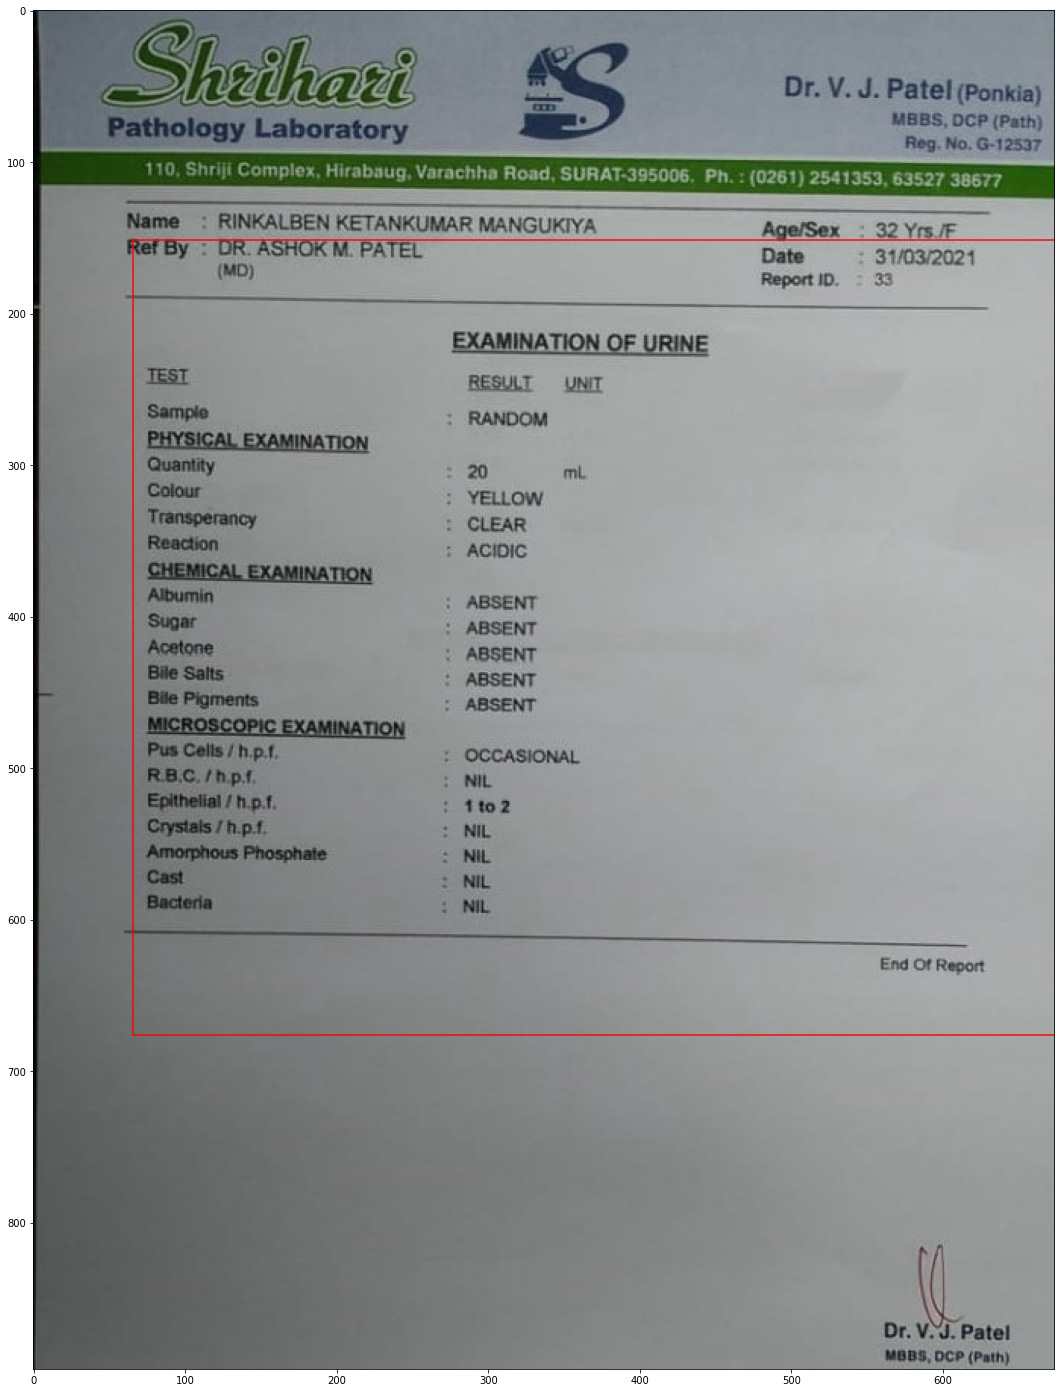

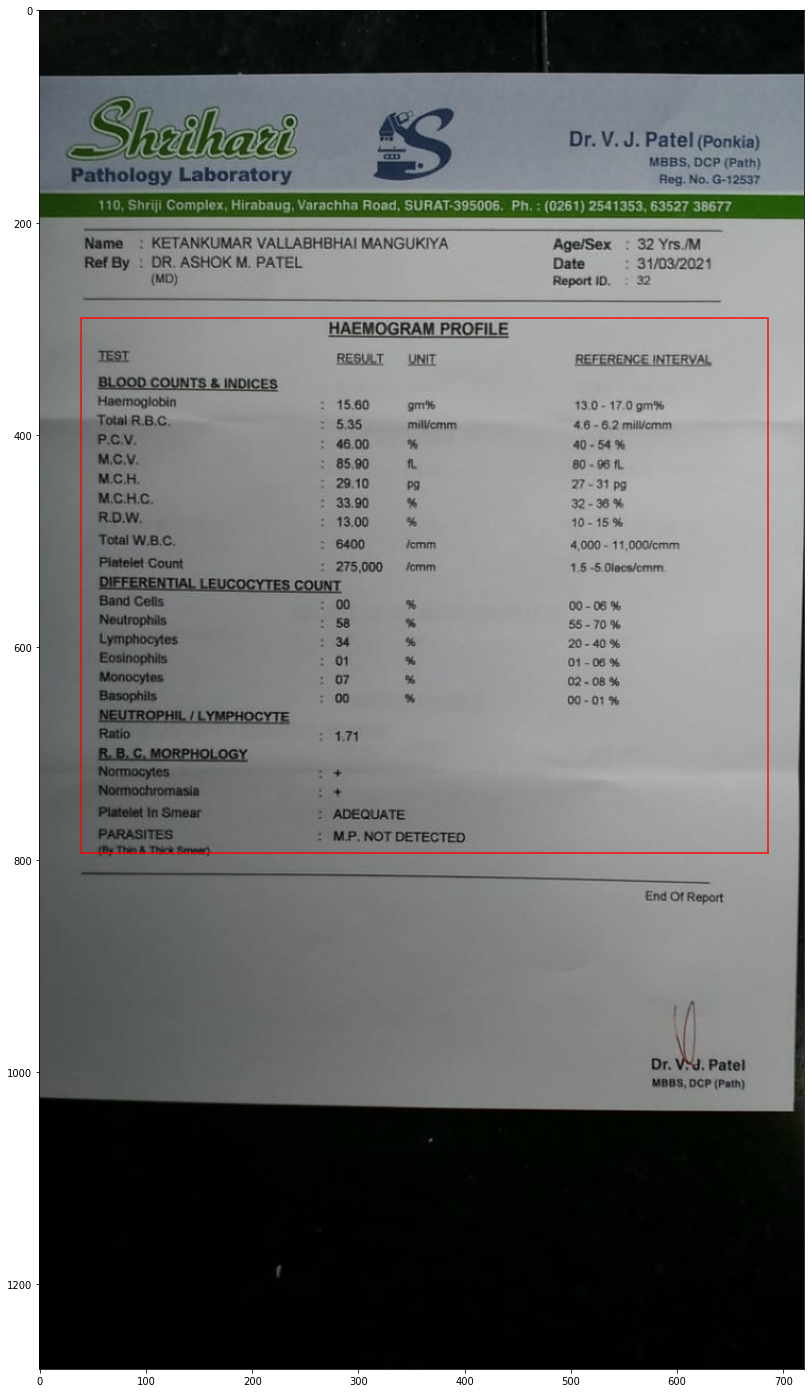

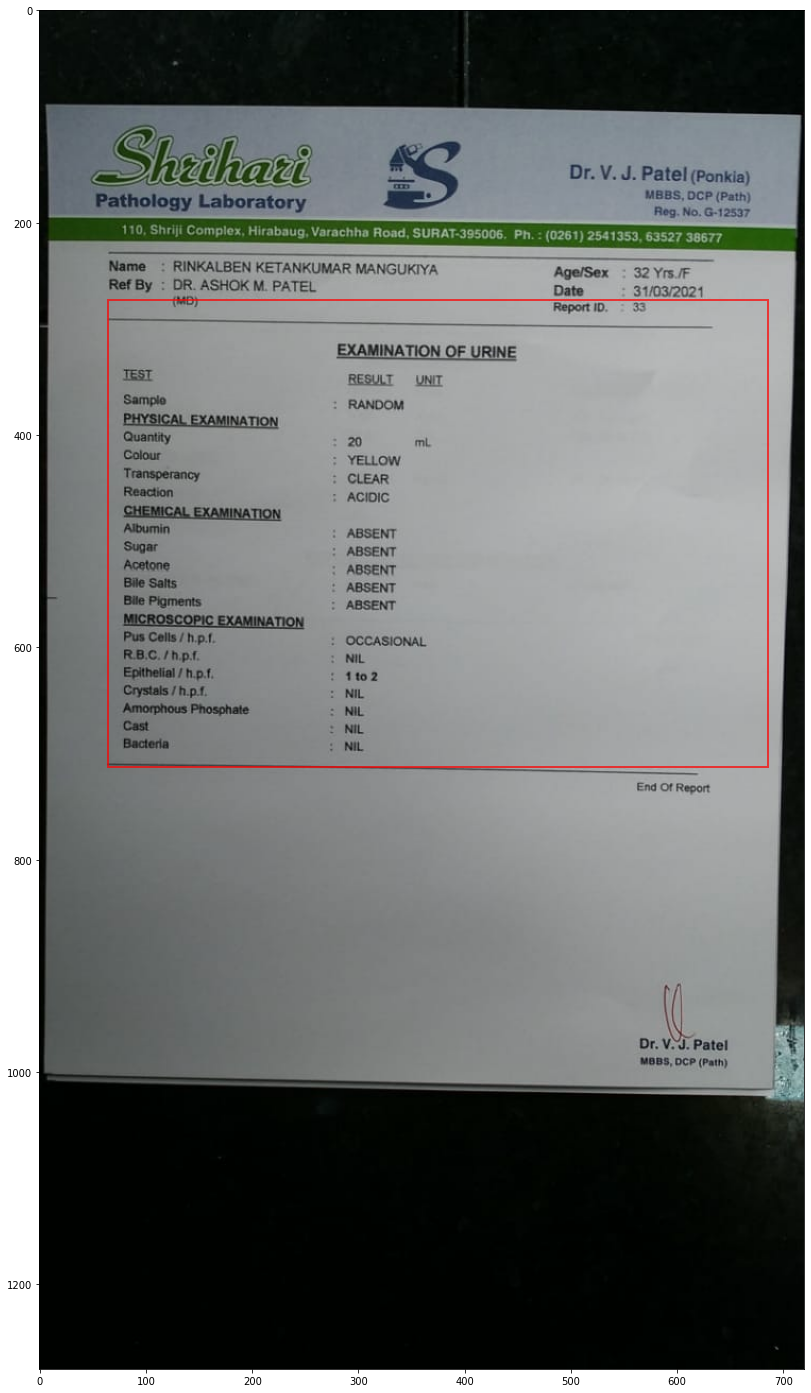

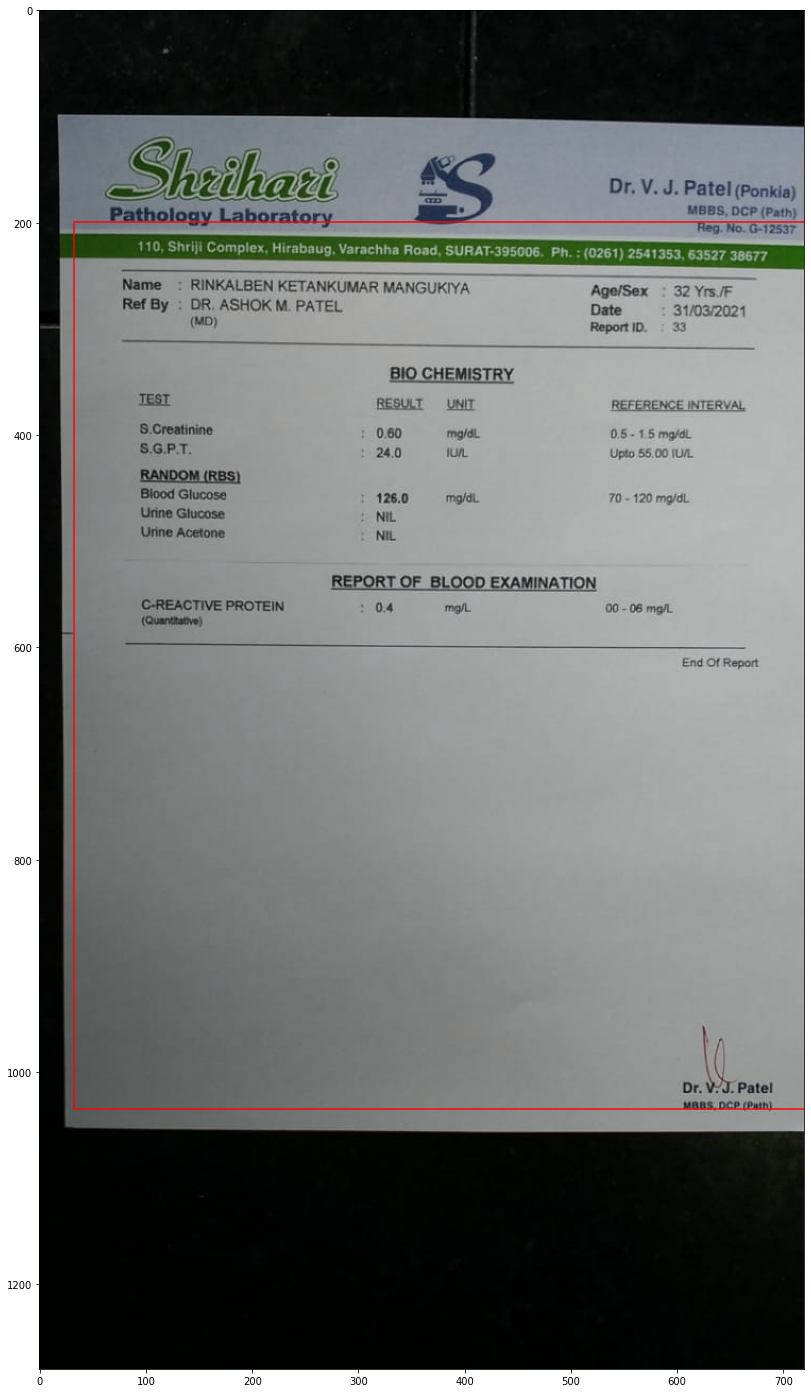

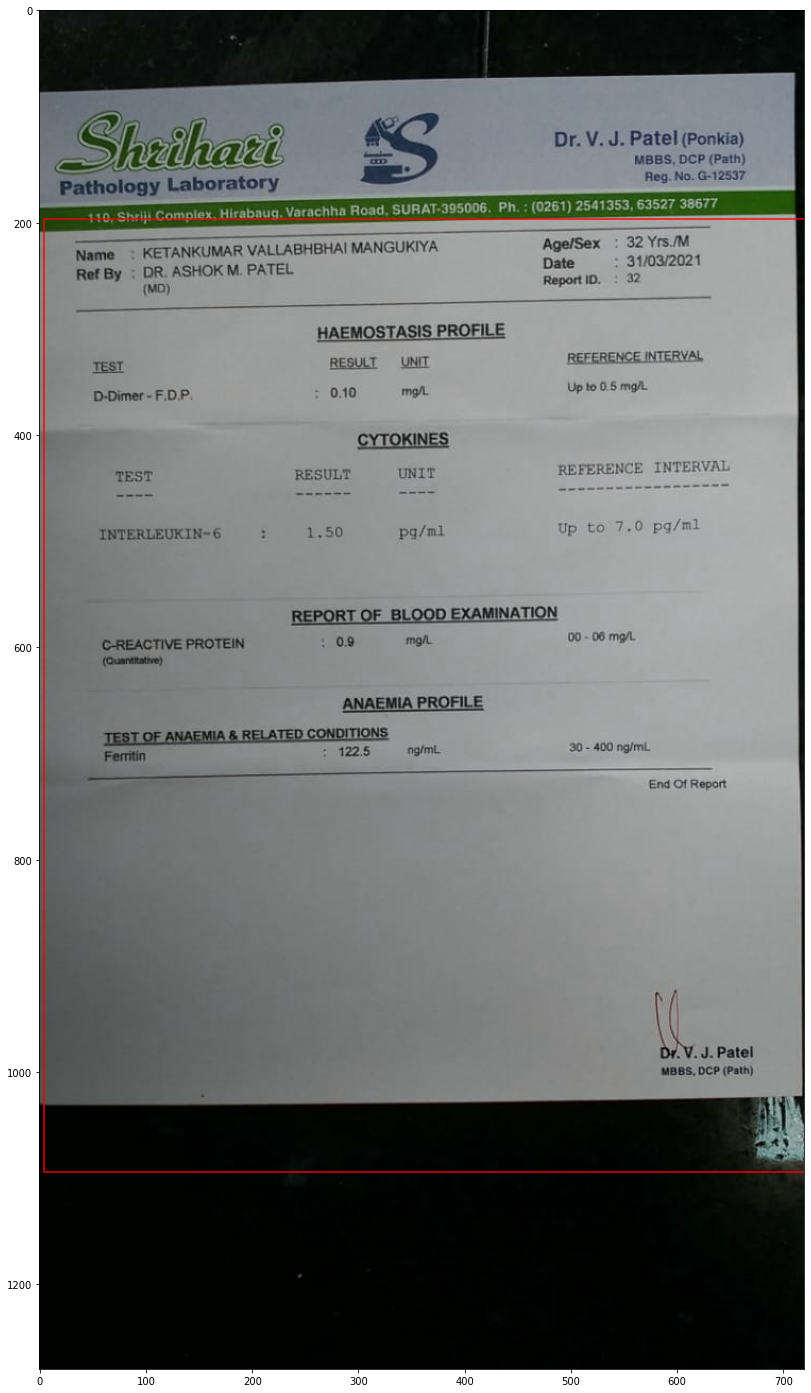

In [51]:
import cv2
import matplotlib.pyplot as plt

from matplotlib.patches import Rectangle

def showImage(img,imfg = True):
    fig,ax = plt.subplots(1,figsize=(25,25))
    ax.imshow(img,cmap = 'gray')
    return ax

img = cv2.imread(gb_path)
#img = cv2.imread("../data/custom_data/R3.jpeg")
#img = cv2.imread(image_file_paths_test[0])
#plot = showImage(img)
#for x,y,w,h,_ in labels_test[0]:    
#    plot.add_patch(Rectangle((x,y),w,h,edgecolor='red',alpha=0.7,facecolor="none",linewidth=2))


for input_image,ratio in test_data:
    
    input_image = tf.expand_dims(input_image,axis = 0)
    detections = inference_model.predict(input_image)
    num_detections = detections.valid_detections[0]
    
    
    #print(model(input_image, training = False))
    #print(detections)
    #print(num_detections)
    
    
    t2 = [detections[0][0][0]/ratio]
    
    img = cv2.imread(gb_path)
    
    plot = showImage(img)
    for x,y,x2,y2 in t2:#labels[indx]:
        w,h = x2 - x,y2 -y
        plot.add_patch(Rectangle((x,y),w,h,edgecolor='red',alpha=0.7,facecolor="none",linewidth=2))

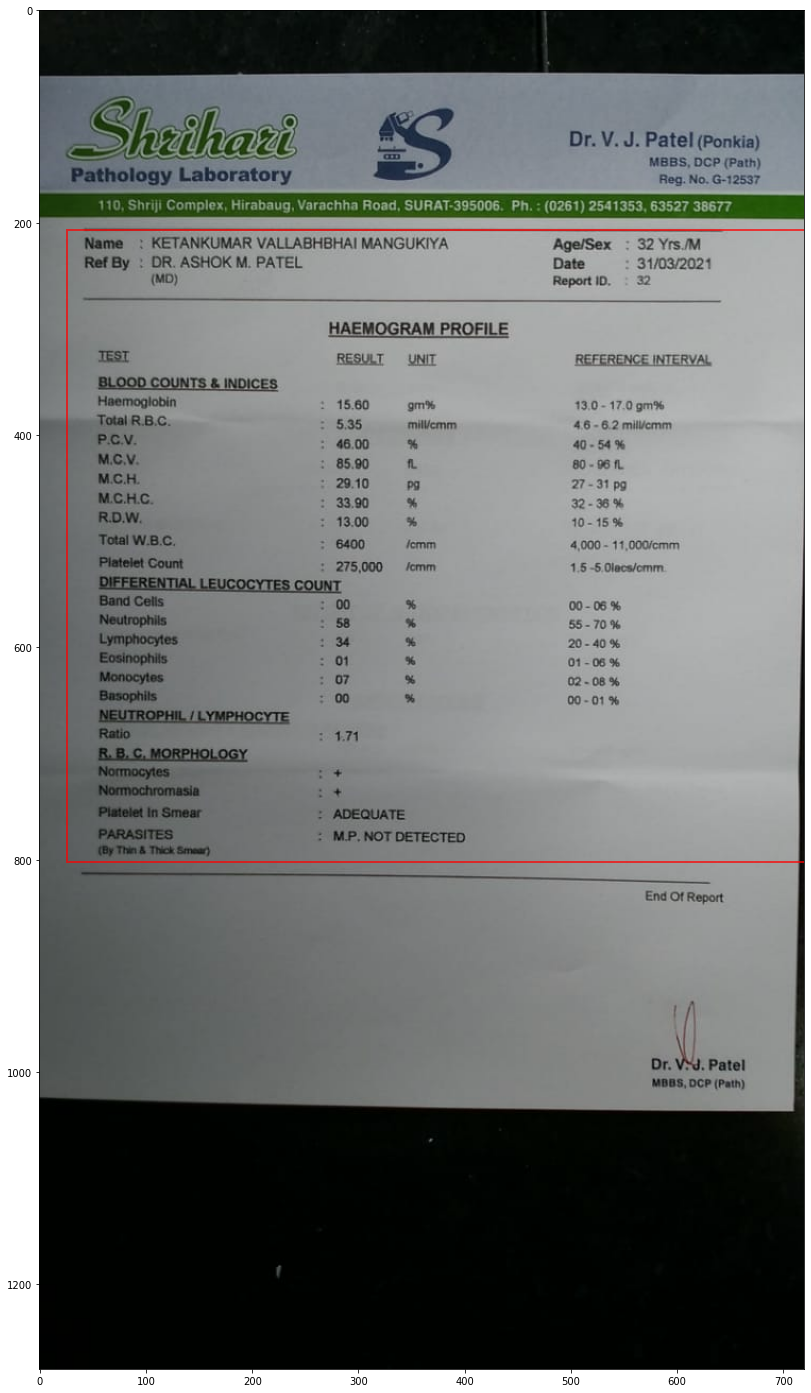

In [46]:
from matplotlib.patches import Rectangle

t2 = [detections[0][0][0]/ratio]
#print(t2)
#from random import randint as rint
#indx = rint(0,len(labels)-1)
#print(indx)
#img = cv2.imread(image_file_paths[indx])

plot = showImage(img)
for x,y,x2,y2 in t2:#labels[indx]:
    w,h = x2 - x,y2 -y
    plot.add_patch(Rectangle((x,y),w,h,edgecolor='red',alpha=0.7,facecolor="none",linewidth=2))

In [ ]:
prd = model(input_image)
prd = tf.concat([prd[...,:4],tf.nn.sigmoid(prd[...,4:])],axis=-1)[0].numpy()
prd

In [ ]:
image_file_paths[2],labels[2]

In [ ]:
sorted(prd.tolist(), key = lambda x: x[-1],reverse = True)